In [335]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import cartopy as cp
from matplotlib.patches import FancyArrowPatch
from scipy.ndimage import map_coordinates
import metpy.calc as mpcalc

This script calculates the displacement vector fields between outlook and pph probability fields, using optical flow tracking algorithms

In [2]:
pph = xr.open_dataset('data/pph/labelled_pph.nc')
outlooks = xr.open_dataset('data/outlooks/grid_outlooks.nc')

In [371]:
test_date = '201104270000'
pph_array = pph.sel(time = test_date)['p_perfect_max'].data/100*255 # normalize to 8-bit image scale
outlook_array = outlooks.sel(time = test_date, outlook = 'Day 1')['prob'].data*255 # normalize to 8-bit image scale

In [372]:
flow = cv.calcOpticalFlowFarneback(outlook_array, pph_array, None, .5, 3, 5, 3, 7, 1.5, 0)


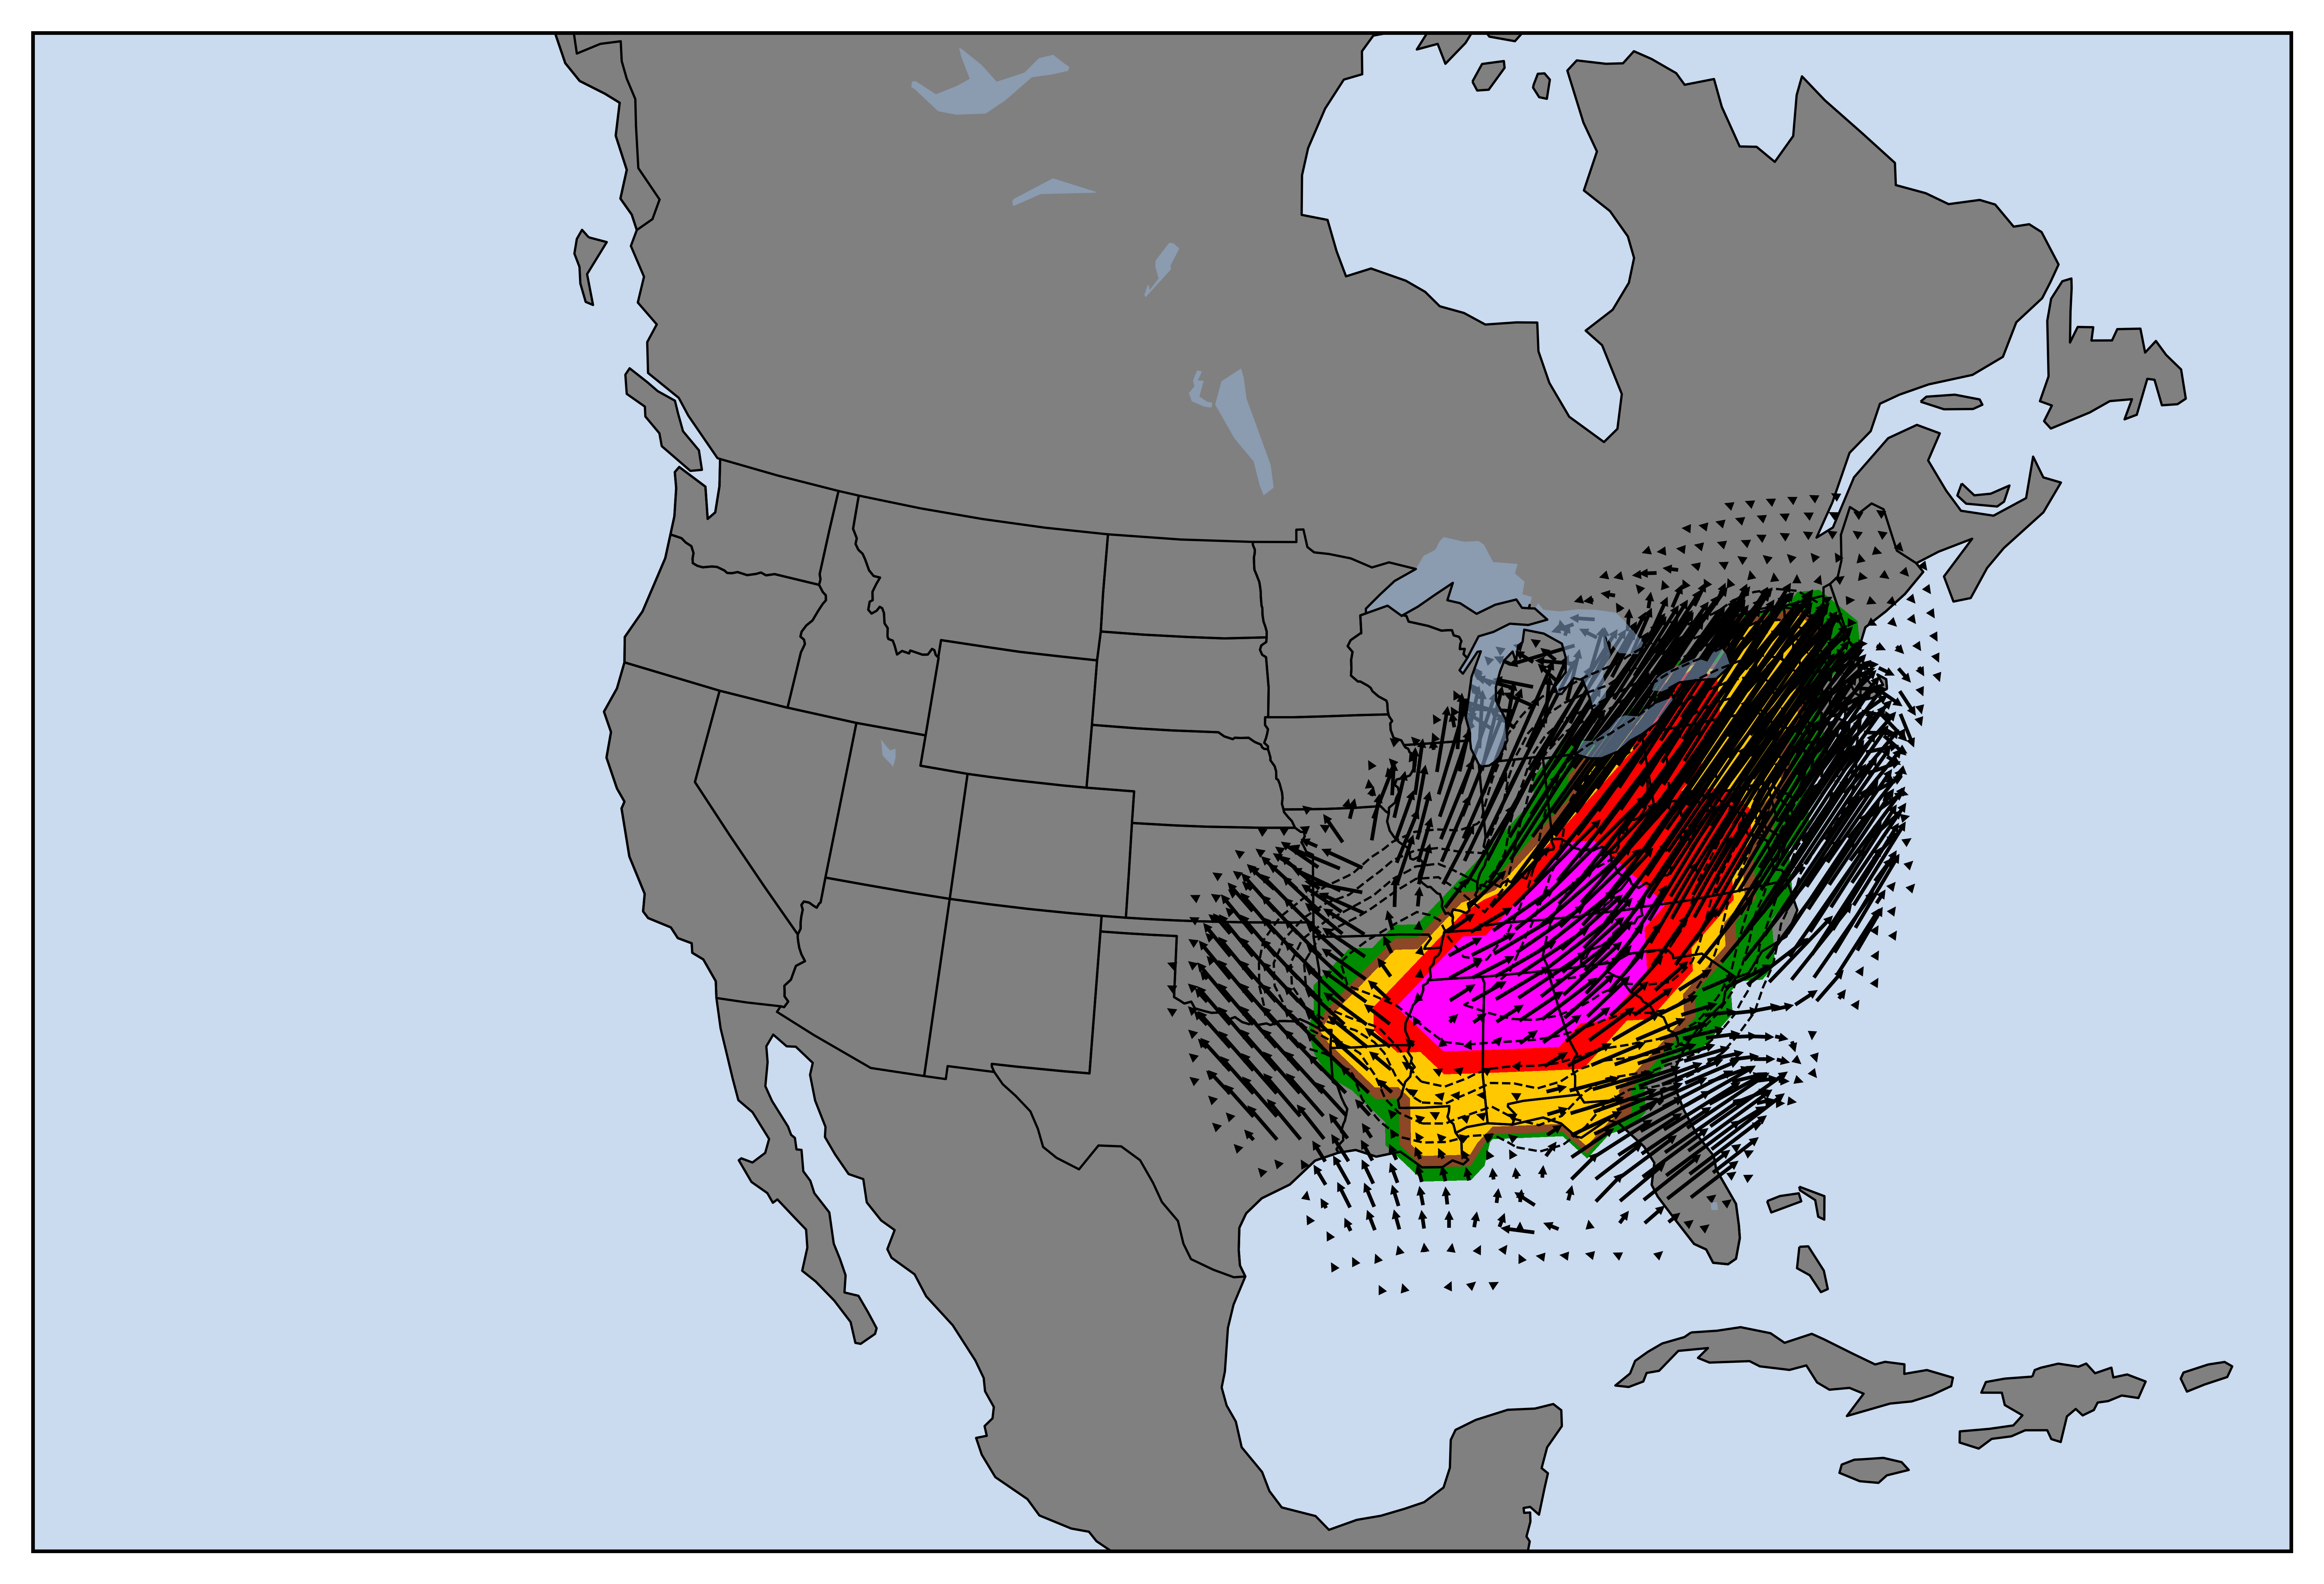

In [395]:
lons = pph.lon.values
lats = pph.lat.values

fig=plt.figure(figsize=(9,6), dpi = 1000)
ax = plt.axes(projection = cp.crs.LambertConformal())
ax.add_feature(cp.feature.LAND,facecolor='grey')
ax.add_feature(cp.feature.OCEAN, alpha = 0.5)
ax.add_feature(cp.feature.COASTLINE,linewidth=0.5)
ax.add_feature(cp.feature.LAKES, alpha = 0.5)
ax.add_feature(cp.feature.STATES,linewidth=0.5)
ax.contourf(lons, lats, outlook_array/255,
                    levels=[.02,.05,.10,.15,.30,.45,.60,1.00], colors=['#008b00','#8b4726','#ffc800', '#ff0000', '#ff00ff', '#912cee', '#104e8b'], transform=cp.crs.PlateCarree())
ax.contour(lons, lats, pph_array/255, levels=[.02,.05,.10,.15,.30,.45,.60,1.00], colors = 'black', linestyles = 'dashed', linewidths = .5, transform=cp.crs.PlateCarree())

mask = (flow[:, :, 0].flatten() > 0.01) | (flow[:, :, 1].flatten() > 0.01)

for i in range(lons.shape[0]):
    for j in range(lats.shape[1]):
        if np.abs(flow[i, j, 0]) > .01 and np.abs(flow[i, j, 1]) > .01:
            end_lon = map_coordinates(lons, [[i + flow[i, j, 1]], [j + flow[i, j, 0]]])
            end_lat = map_coordinates(lats, [[i + flow[i, j, 1]], [j + flow[i, j, 0]]])
            ax.add_patch(FancyArrowPatch((lons[i, j], lats[i, j]), (end_lon[0], end_lat[0]), transform=cp.crs.PlateCarree(), color = 'black', mutation_scale=4, linewidth = .01))

#for lon, lat, u, v in zip(lons.flatten()[mask], lats.flatten()[mask], flow[:, :, 0].flatten()[mask], flow[:, :, 1].flatten()[mask]):
    #ax.arrow(lon, lat, u, v, transform=cp.crs.PlateCarree(), length_includes_head = True, width = .01)
#    ax.add_patch(FancyArrowPatch((lon, lat), (lon + u, lat + v), transform=cp.crs.PlateCarree(), linewidth = .2, color = 'blue'))

In [374]:
# weighted mean shift
x_shift = np.average(flow[:, :, 0], weights = outlook_array)
y_shift = np.average(flow[:, :, 1], weights = outlook_array)
x_shift*80, y_shift * 80


(292.45103960609106, 331.1879183590431)

In [381]:
# weighted mean divergence, range should be approximately (-1, 1)
# try basic method with np.gradient. Will then use metpy gradient but need flow vectors to have proper units first
div = np.gradient(flow[:, :, 0])[1] + np.gradient(flow[:, :, 1])[0]
total_div = np.average(div, weights = outlook_array)
total_div


curl = np.gradient(flow[:, :, 0])[0] + np.gradient(flow[:, :, 1])[1]
total_curl = np.average(curl, weights = outlook_array)

total_div

0.4358096090196644

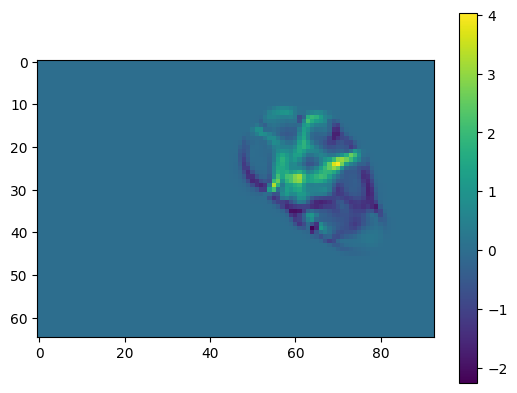

In [382]:
plt.imshow(div)
plt.colorbar()